In [1]:
%cd ..

/nfs/scistore16/edelgrp/fzimin/depth-poset


/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os

import numpy as np
import pandas as pd
import pickle as pkl
import networkx as nx
import gudhi as gh

from src.depth import DepthPoset


#from tqdm.notebook import tqdm
from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib import cm
from networkx import draw_networkx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from src.depth import DepthPoset

# Load and Format the Data

In [3]:
# define file paths
directory = "results/scores-on-random-alpha-complexes"
paths = np.sort([f'{directory}/{f}' for f in os.listdir(directory)])

paths = paths[pd.Series(paths).apply(lambda s: s.split('.')[0].split('/')[-1]).values > '2024-12-26 18:04:00']

# load them
ls = []
for path in tqdm(paths, total=len(paths)):
    with open(path, 'rb') as file:
        ls.append(pkl.load(file))

100%|██████████| 20/20 [00:00<00:00, 1264.91it/s]


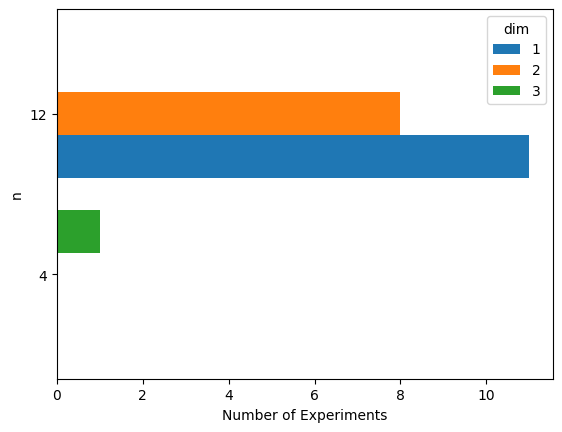

In [4]:
df_cases = pd.DataFrame(ls)
df_cases.insert(0, 'index', df_cases.index)

df_cases[['n', 'dim', 'depth poset']].groupby(['n', 'dim']).count().reset_index().pivot(columns='dim', index='n', values='depth poset').fillna(0).astype(int).plot(kind='barh', width=0.8)
plt.xlabel('Number of Experiments')
plt.savefig('raports/pics/scores - cases.png')

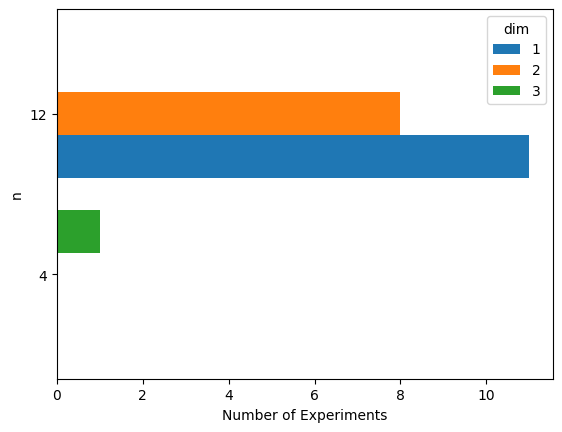

In [5]:
df_cases = df_cases[df_cases['dim'] <= 4]

df_cases[['n', 'dim', 'depth poset']].groupby(['n', 'dim']).count().reset_index().pivot(columns='dim', index='n', values='depth poset').fillna(0).astype(int).plot(kind='barh', width=0.8)
plt.xlabel('Number of Experiments')
plt.savefig('raports/pics/scores - cases.png')

In [6]:
print(f'df_cases.shape = {df_cases.shape}')
df_cases.head()

df_cases.shape = (20, 8)


,index,n,dim,points,stree,depth poset,poset scores,node scores
0,0,4,3,"[[0.004445110763837579, 0.9121173781048797, 0....",<gudhi.simplex_tree.SimplexTree object at 0x7f...,<src.depth.DepthPoset object at 0x7f49172a3910>,"[{'object': 'full', 'avarage_maximal_chain': 1...","[{'object': 'full', 'node': ShallowPair([0.000..."
1,1,12,2,"[[0.2926356262953803, 0.09672497620837472], [0...",<gudhi.simplex_tree.SimplexTree object at 0x7f...,<src.depth.DepthPoset object at 0x7f4917319a10>,"[{'object': 'full', 'avarage_maximal_chain': 2...","[{'object': 'full', 'node': ShallowPair([0.000..."
2,2,12,2,"[[0.9542474572860464, 0.14372378326287416], [0...",<gudhi.simplex_tree.SimplexTree object at 0x7f...,<src.depth.DepthPoset object at 0x7f491731ba50>,"[{'object': 'full', 'avarage_maximal_chain': 2...","[{'object': 'full', 'node': ShallowPair([0.000..."
3,3,12,2,"[[0.07588725972153976, 0.5999819281607667], [0...",<gudhi.simplex_tree.SimplexTree object at 0x7f...,<src.depth.DepthPoset object at 0x7f49173a0b50>,"[{'object': 'full', 'avarage_maximal_chain': 1...","[{'object': 'full', 'node': ShallowPair([0.000..."
4,4,12,1,"[[0.8425643305402404], [0.0106300228390106], [...",<gudhi.simplex_tree.SimplexTree object at 0x7f...,<src.depth.DepthPoset object at 0x7f49169381d0>,"[{'object': 'full', 'avarage_maximal_chain': 3...","[{'object': 'full', 'node': ShallowPair([0.000..."


# Are they Trees

In [7]:
df_cases['is tree'] = [len(nx.cycle_basis(dp.get_transitive_reduction().to_undirected())) == 0 for dp in tqdm(df_cases['depth poset'], total=len(df_cases))]
print(f"There are {df_cases['is tree'].count() - df_cases['is tree'].sum()}/{df_cases['is tree'].count()} depth posets are not trees.")

100%|██████████| 20/20 [00:00<00:00, 1178.04it/s]

There are 4/20 depth posets are not trees.


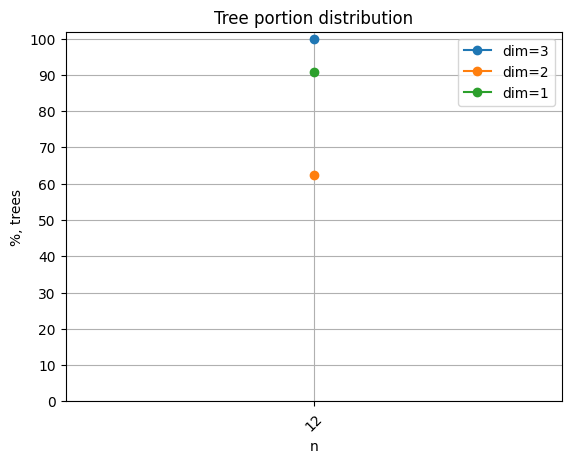

In [8]:
plt.title('Tree portion distribution')

for dim in pd.unique(df_cases['dim']):
    y = df_cases.loc[df_cases['dim'] == dim, ['n', 'is tree']].groupby('n').sum()/df_cases.loc[df_cases['dim'] == dim, ['n', 'is tree']].groupby('n').count()
    plt.plot(np.arange(len(y)), 100*y, label=f'dim={dim}', marker='o')
plt.legend()
plt.xticks(np.arange(len(y)), labels=y.index, rotation=45)
plt.xlabel('n')
plt.yticks(np.arange(0, 101, 10))
plt.ylabel('%, trees')

plt.grid(True)
plt.show()

## Raporting the Case with Cyclic Depth Poset for Cloud dim=1

In [9]:
from src.depth import get_ordered_border_matrix_from_simplex_tree

In [10]:
try:
    min_n = df_cases[(~df_cases['is tree'])&(df_cases['dim'] == 1)]['n'].min()
    id_cyclic = np.random.choice(df_cases[(~df_cases['is tree'])&(df_cases['dim'] == 1)&(df_cases['n'] <= min_n)].index)
    
    dp_cyclic = df_cases.loc[id_cyclic, "depth poset"]
    st_cyclic = df_cases.loc[id_cyclic, "stree"]
    ps_cyclic = df_cases.loc[id_cyclic, "points"]
except ValueError as msg:
    print(f'Not found cyclic depth poset dim=1: {msg}')
    dp_cyclic = DepthPoset()
    st_cyclic = gh.SimplexTree()
    ps_cyclic = []
    pass

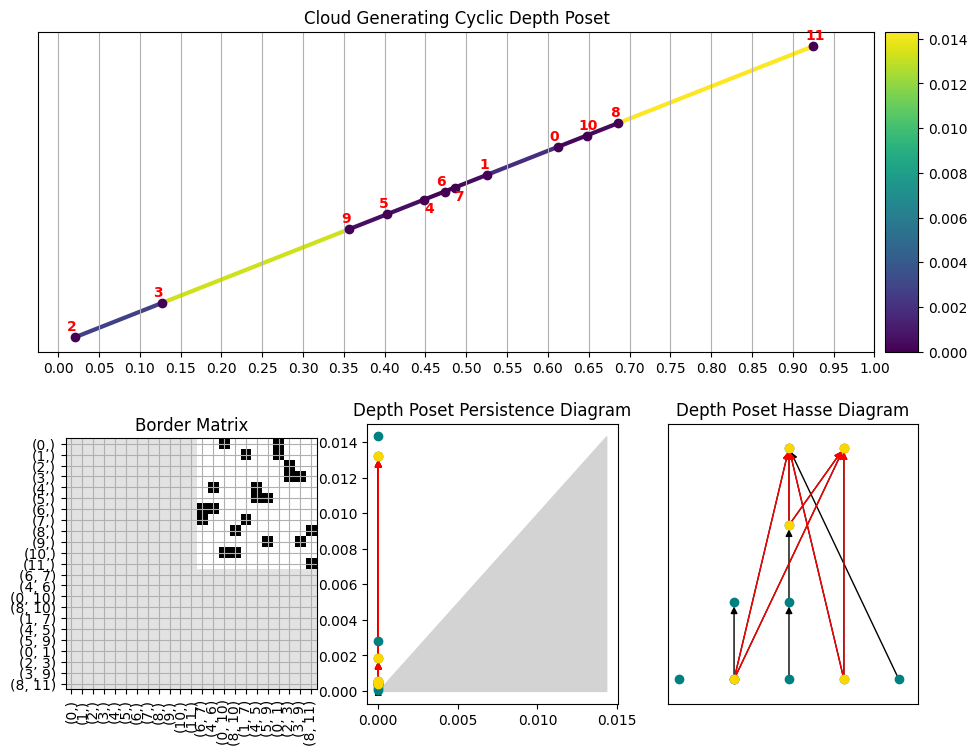

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(11, 8))  # Create 2 rows and 3 columns of subplots

# Remove the second top subplot (merge top two into one large subplot)
fig.delaxes(axs[0, 1])  # Remove the unnecessary subplot
fig.delaxes(axs[0, 2])  # Remove the third subplot in the top row

# Adjust the remaining top subplot to span the full width
axs[0, 0].set_position([0.1, 0.55, 0.76, 0.4])  # [left, bottom, width, height]

axs[0, 0].set_title(f'Cloud Generating Cyclic Depth Poset')
filtration_values = np.unique(np.append([value for simplex, value in st_cyclic.get_filtration()], 0))

cmap = plt.get_cmap('viridis')
norm = Normalize(vmin=filtration_values[0], vmax=filtration_values[-1])

for simplex, value in st_cyclic.get_filtration():
    color = cmap(norm(value))
    if len(simplex) == 1:
        x, y = ps_cyclic[simplex][0]*np.ones(2)
        axs[0, 0].scatter(x, y, color=color, s=36, zorder=2)
        axs[0, 0].text(x - 0.01 + 0.01*int(simplex[0] in [4, 7]), 
                       y + 0.02 - 0.06*int(simplex[0] in [4, 7]), 
                       str(simplex[0]), color='red', weight='semibold')
    if len(simplex) == 2:
        x, y = np.transpose(ps_cyclic[simplex]*np.ones([2, 2]))
        axs[0, 0].plot(x, y, color=color, zorder=1, linewidth=3)

sm = ScalarMappable(cmap=cmap, norm=norm)
axs[0, 0].set_xticks(np.linspace(0, 1, 21))
axs[0, 0].set_yticks([])
axs[0, 0].grid(True)

cbar_ax = fig.add_axes([0.87, 0.55, 0.03, 0.4])
cbar = plt.colorbar(sm, cax=cbar_ax)

# Bottom left subplot: Depth Poset Persistence Diagram
axs[1, 1].set_title(f'Depth Poset Persistence Diagram')
g = dp_cyclic.get_transitive_reduction().to_undirected()
cycles = nx.cycle_basis(g)
if len(cycles) == 0:
    cycle_nodes = []
    cycle_edges = []
else:
    cycle_nodes = [] if len(cycles) == 0 else np.concatenate(cycles)
    cycle_edges = np.concatenate([np.array([cycle, np.append(cycle[1:], cycle[0])]) for cycle in cycles], axis=1)
    cycle_edges = np.concatenate([cycle_edges, [cycle_edges[1], cycle_edges[0]]], axis=1).transpose()
    cycle_edges = [tuple(edge) for edge in cycle_edges]
node_condition = lambda node: node in cycle_nodes
edge_condition = lambda edge: edge in cycle_edges

nx.draw_networkx(dp_cyclic.get_transitive_reduction(), 
                 pos=dp_cyclic.persistant_layout(), ax=axs[1, 1], 
                 node_color='teal', edge_color='black',
                 node_size=36, with_labels=False, hide_ticks=False)
nx.draw_networkx(dp_cyclic.subposet(node_condition=node_condition, edge_condition=edge_condition).get_transitive_reduction(), 
                 pos=dp_cyclic.persistant_layout(), ax=axs[1, 1], 
                 node_color='gold', edge_color='red',
                 node_size=36, with_labels=False, hide_ticks=False)

axs[1, 1].fill_between([0, max(filtration_values)], [0, max(filtration_values)], [0, 0], color='lightgrey')
axs[1, 1].set_xlim(*(np.max(filtration_values)*np.array([-0.05, 1.05])))
axs[1, 1].set_ylim(*(np.max(filtration_values)*np.array([-0.05, 1.05])))

# Bottom right subplot: Depth Poset Hasse Diagram
axs[1, 2].set_title(f'Depth Poset Hasse Diagram')
nx.draw_networkx(dp_cyclic.get_transitive_reduction(), 
                 pos=dp_cyclic.hasse_layout(), ax=axs[1, 2], 
                 node_color='teal', edge_color='black',
                 node_size=36, with_labels=False, hide_ticks=True)
nx.draw_networkx(dp_cyclic.subposet(node_condition=node_condition, edge_condition=edge_condition).get_transitive_reduction(), 
                 pos=dp_cyclic.hasse_layout(), ax=axs[1, 2], 
                 node_color='gold', edge_color='red',
                 node_size=36, with_labels=False, hide_ticks=True)

axs[1, 0].set_title('Border Matrix')
simplices, matrix = get_ordered_border_matrix_from_simplex_tree(st_cyclic)
matrix = np.array(matrix, dtype=float)
matrix[:len(ps_cyclic), :len(ps_cyclic)] = 0.2
matrix[len(ps_cyclic):, len(ps_cyclic):] = 0.2
matrix[len(ps_cyclic):, :len(ps_cyclic)] = 0.2

axs[1, 0].imshow(matrix, cmap='Greys')
axs[1, 0].set_xticks(np.arange(len(simplices)), labels=simplices, rotation=90)
axs[1, 0].set_yticks(np.arange(len(simplices)), labels=simplices, rotation=0)
axs[1, 0].grid(True)


plt.savefig('raports/pics/cyclic-dim1.png')

# Plot Poset scores

In [12]:
from src import poset_scores

In [13]:
df_poset_scores = [pd.DataFrame(i['poset scores']) for i in ls]
for i in range(len(df_poset_scores)):
    df_poset_scores[i].insert(0, 'index', value=i)
df_poset_scores = pd.concat(df_poset_scores)

df_poset_scores = df_cases[['index', 'n', 'dim']].join(df_poset_scores.set_index('index'), on='index')
df_poset_scores = df_poset_scores.reset_index(drop=True)

print(f'df_poset_scores.shape = {df_poset_scores.shape}')
df_poset_scores.head()

df_poset_scores.shape = (50, 16)


,index,n,dim,object,avarage_maximal_chain,cycles_dimension,height,minimum_maximal_chain,number_of_components,number_of_edges_in_closure,number_of_edges_in_reduction,number_of_maximal_nodes,number_of_minimal_nodes,number_of_nodes,number_of_relations,width
0,0,4,3,full,1.666667,0,1,1,2,2,2,2,3,4,2,3
1,0,4,3,subposet dim=0,2.000000,0,1,2,1,2,2,1,2,3,2,2
2,0,4,3,subposet dim=1,1.000000,0,0,1,1,0,0,1,1,1,0,1
3,0,4,3,subposet dim=2,0.000000,0,0,0,0,0,0,0,0,0,0,0
4,1,12,2,full,2.076923,1,2,1,6,17,12,7,11,17,12,11


In [14]:
interesting_poset_scores = [poset_scores.number_of_nodes, 
                            poset_scores.number_of_relations, 
                            poset_scores.number_of_components, 
                            poset_scores.cycles_dimension, 
                            poset_scores.number_of_minimal_nodes, 
                            poset_scores.number_of_maximal_nodes, 
                            poset_scores.height, 
                            poset_scores.width, 
                            poset_scores.minimum_maximal_chain, 
                            poset_scores.avarage_maximal_chain
                           ]
interesting_poset_scores_names = [score.__name__ for score in interesting_poset_scores]

for score in interesting_poset_scores:
    if not (score.__name__ in df_poset_scores.columns):
        df_poset_scores[score.__name__] = np.nan

missed_values = df_poset_scores[[score.__name__ for score in interesting_poset_scores]].isna().sum().sum()
print(f'There are {missed_values} values missed and should be restored.')
with tqdm(total=missed_values) as pbar:
    for i in df_poset_scores.index:
        if df_poset_scores.loc[i, interesting_poset_scores_names].isna().any():
            dp = df_cases.loc[df_cases['index'] == df_poset_scores.loc[i, 'index'], 'depth poset'].values[0]
            if df_poset_scores.loc[i, 'object'] != 'full':
                dim = int(df_poset_scores.loc[i, 'object'].replace('subposet dim=', ''))
                dp = dp.subposet_dim(dim)
            for score in interesting_poset_scores:
                if pd.isna(df_poset_scores.loc[i, score.__name__]):
                    df_poset_scores.loc[i, score.__name__] = score(dp)
                    pbar.update()
        
print(f'df_poset_scores.shape = {df_poset_scores.shape}')
df_poset_scores.head()

There are 0 values missed and should be restored.


0it [00:00, ?it/s]

df_poset_scores.shape = (50, 16)


,index,n,dim,object,avarage_maximal_chain,cycles_dimension,height,minimum_maximal_chain,number_of_components,number_of_edges_in_closure,number_of_edges_in_reduction,number_of_maximal_nodes,number_of_minimal_nodes,number_of_nodes,number_of_relations,width
0,0,4,3,full,1.666667,0,1,1,2,2,2,2,3,4,2,3
1,0,4,3,subposet dim=0,2.000000,0,1,2,1,2,2,1,2,3,2,2
2,0,4,3,subposet dim=1,1.000000,0,0,1,1,0,0,1,1,1,0,1
3,0,4,3,subposet dim=2,0.000000,0,0,0,0,0,0,0,0,0,0,0
4,1,12,2,full,2.076923,1,2,1,6,17,12,7,11,17,12,11


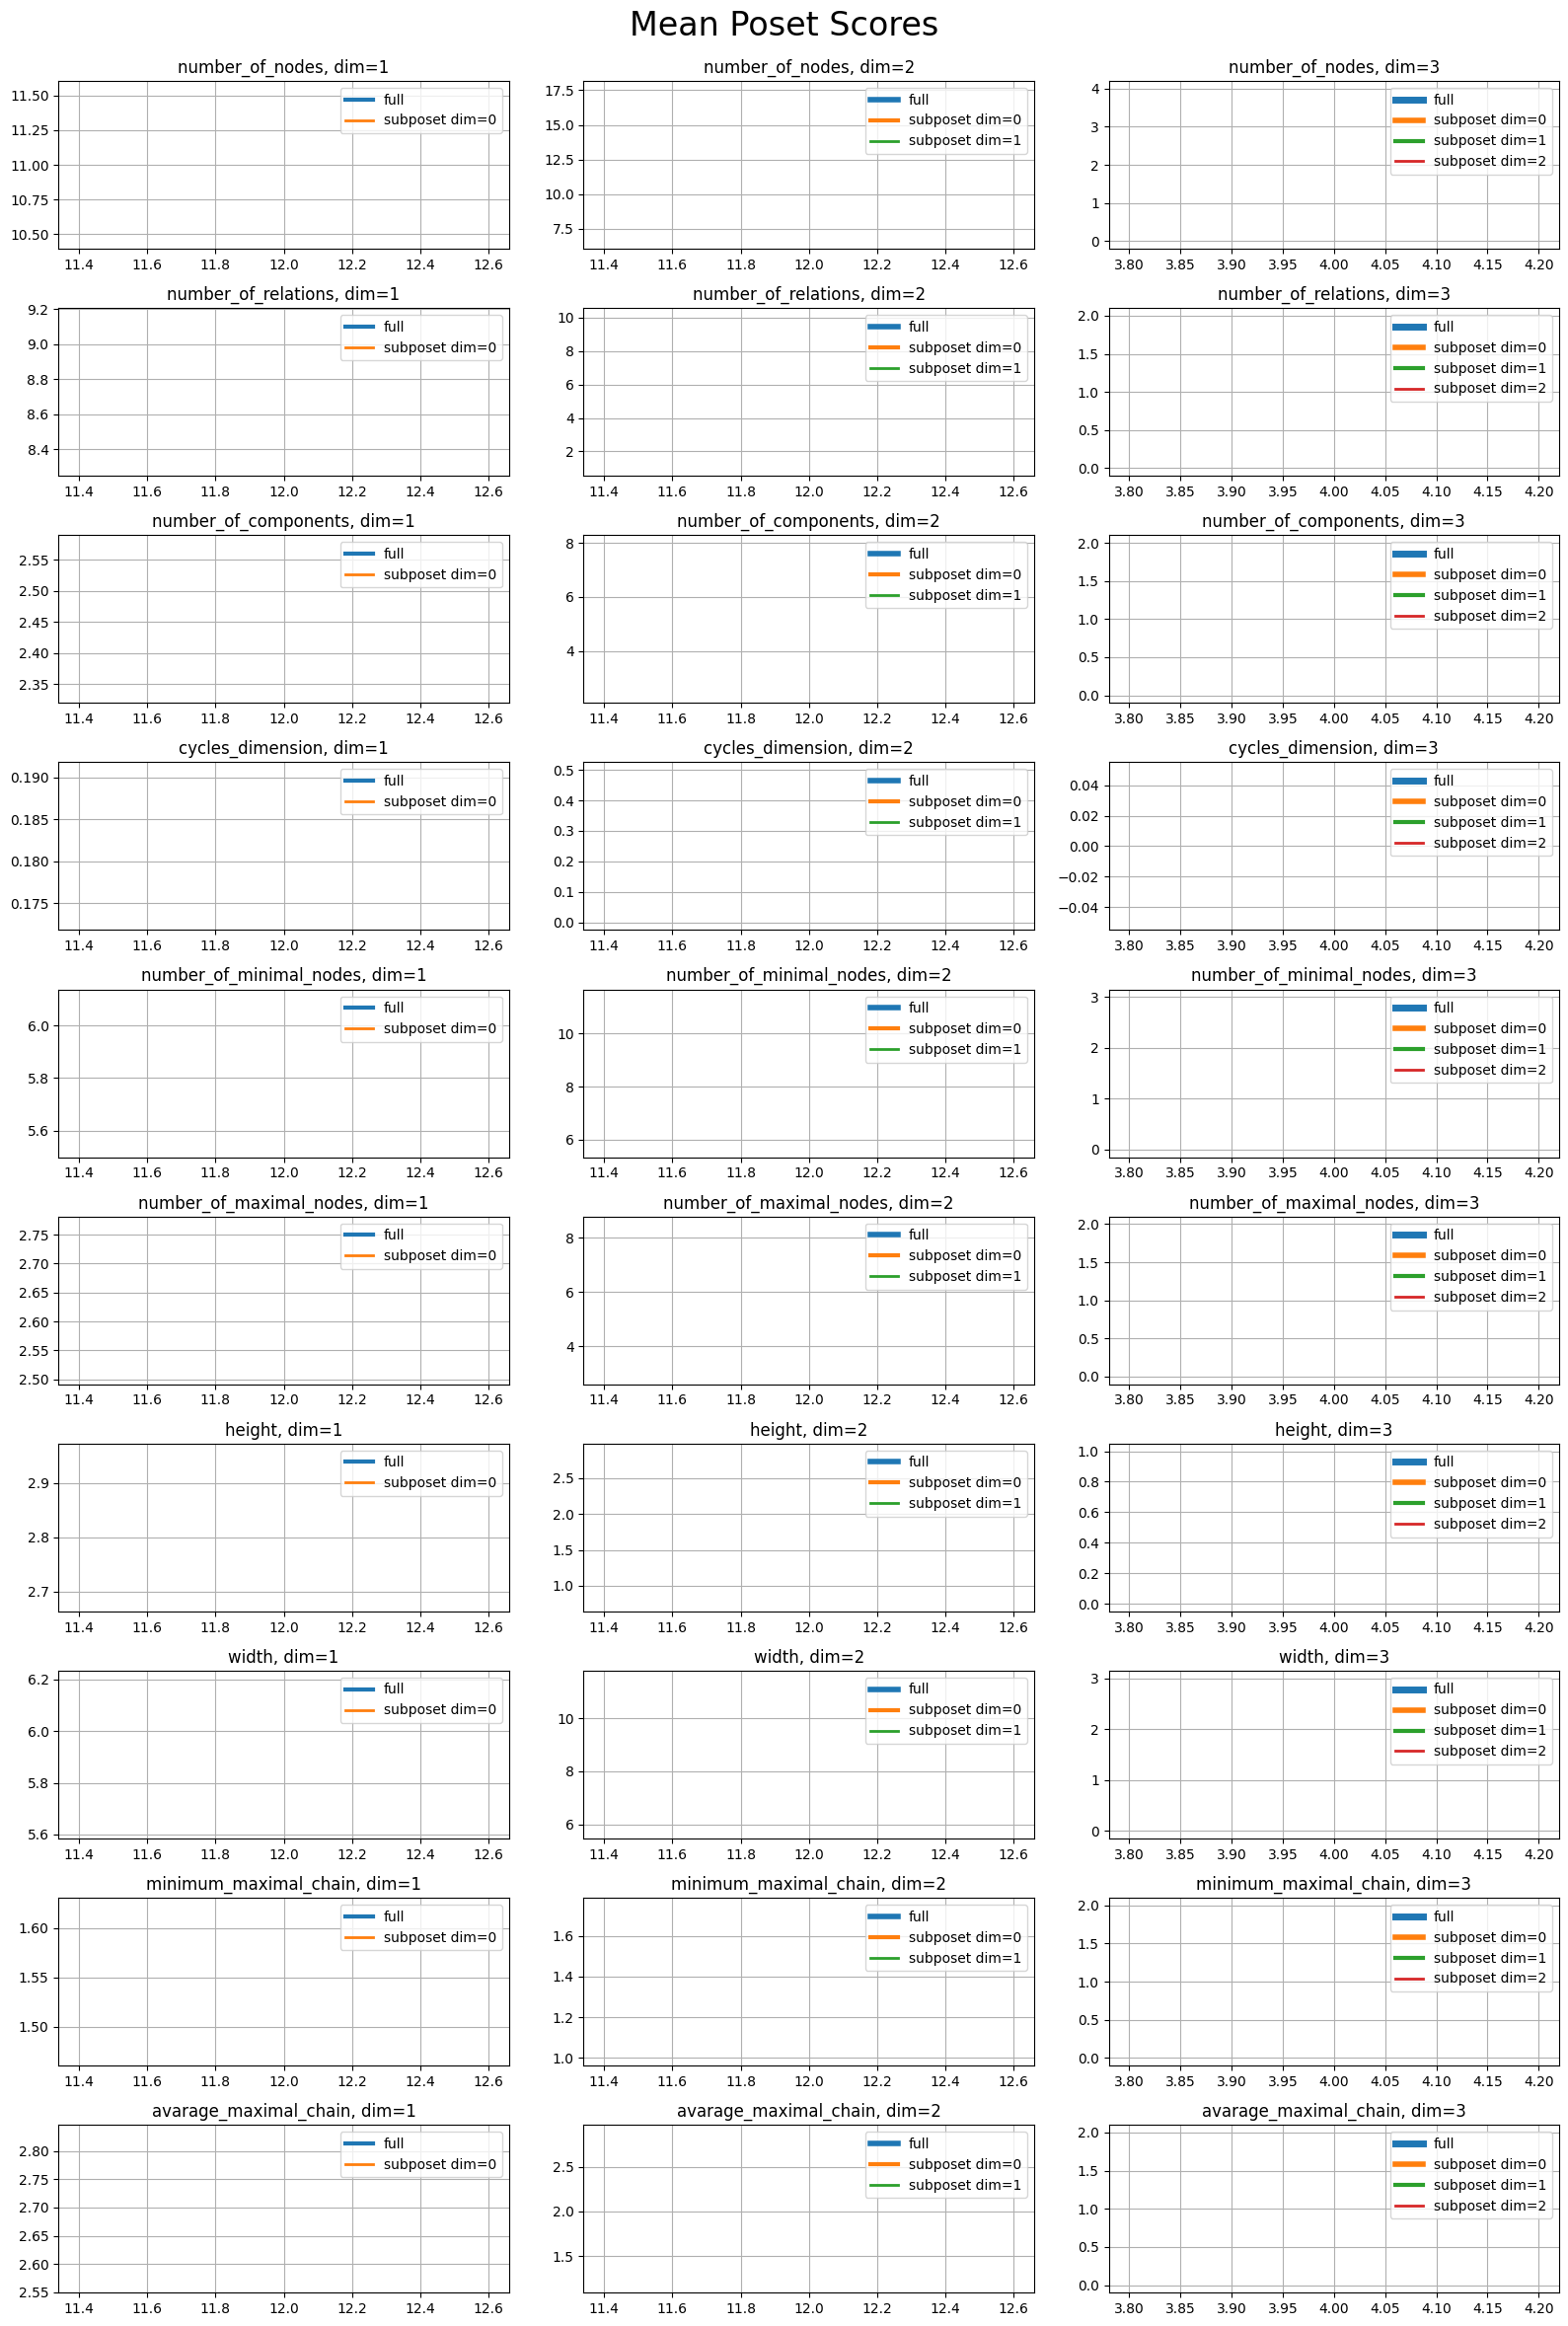

In [15]:
#score_cols = df_poset_scores.columns[4:]
score_cols = interesting_poset_scores_names
max_dim = df_poset_scores['dim'].max()

fig, axs = plt.subplots(len(score_cols), max_dim)

fig.suptitle('Mean Poset Scores', fontsize=24)
fig.set_figwidth(16)
fig.set_figheight(24)

for iscore, score in enumerate(score_cols):
    for dim in range(1, max_dim + 1):
        title = f'{score}, dim={dim}'
        axs[iscore, dim - 1].set_title(title)
        df_use = df_poset_scores[df_poset_scores['dim'] == dim][['n', 'object', score]].groupby(['n', 'object']).mean().reset_index().pivot(columns='object', index='n', values=score)
        for icol, col in enumerate(df_use.columns):
            axs[iscore, dim - 1].plot(df_use.index, df_use[col], label=col, linewidth=(len(df_use.columns) + 1 - icol))
        axs[iscore, dim - 1].legend()
        axs[iscore, dim - 1].grid(True)
        
plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig('raports/pics/scores - mean poset scores.png')

# Plot Node Scores

In [16]:
from src import node_scores

In [17]:
df_node_scores = [pd.DataFrame(i['node scores']) for i in ls]
for i in range(len(df_node_scores)):
    df_node_scores[i].insert(0, 'index', value=i)
df_node_scores = pd.concat(df_node_scores)


df_node_scores = df_cases[['index', 'n', 'dim']].join(df_node_scores.set_index('index'), on='index').reset_index(drop=True)

print(f'df_node_scores.shape = {df_node_scores.shape}')
df_node_scores.head()

df_node_scores.shape = (502, 14)


,index,n,dim,object,node,ancestors_cycles_dimension,ancestors_height,ancestors_number,ancestors_width,incomparable_number,successors_cycles_dimension,successors_height,successors_number,successors_width
0,0,4,3,full,"ShallowPair([0.0000, 0.1232], source=((1,), (1...",0,0,0,0,1,0,0,2,2
1,0,4,3,subposet dim=0,"ShallowPair([0.0000, 0.1232], source=((1,), (1...",0,0,0,0,0,0,0,2,2
2,0,4,3,full,"ShallowPair([0.0000, 0.0650], source=((3,), (2...",0,0,1,1,2,0,0,0,0
3,0,4,3,subposet dim=0,"ShallowPair([0.0000, 0.0650], source=((3,), (2...",0,0,1,1,1,0,0,0,0
4,0,4,3,full,"ShallowPair([0.0000, 0.0110], source=((2,), (0...",0,0,1,1,2,0,0,0,0


In [18]:
interesting_node_scores = [node_scores.ancestors_number,
                           node_scores.ancestors_height, 
                           node_scores.ancestors_width, 
                           node_scores.ancestors_cycles_dimension, 
                           node_scores.successors_number,
                           node_scores.successors_height,
                           node_scores.successors_width, 
                           node_scores.successors_cycles_dimension, 
                           ]
interesting_node_scores_names = [score.__name__ for score in interesting_node_scores]

for score in interesting_node_scores:
    if not (score.__name__ in df_node_scores.columns):
        df_node_scores[score.__name__] = np.nan

missed_values = df_node_scores[[score.__name__ for score in interesting_node_scores]].isna().sum().sum()
print(f'There are {missed_values} values missed and should be restored.')

with tqdm(total=missed_values) as pbar:
    for i in df_node_scores.index:
        if df_node_scores.loc[i, interesting_node_scores_names].isna().any():
            dp = df_cases.loc[df_cases['index'] == df_node_scores.loc[i, 'index'], 'depth poset'].values[0]
            node = df_node_scores.loc[i, 'node']
            if df_node_scores.loc[i, 'object'] != 'full':
                dp_dim = int(df_node_scores.loc[i, 'object'].replace('subposet dim=', ''))
                dp = dp.subposet_dim(dp_dim)
            for score in interesting_node_scores:
                if pd.isna(df_node_scores.loc[i, score.__name__]):
                    df_node_scores.loc[i, score.__name__] = score(dp, node)
                    pbar.update()
        
print(f'df_node_scores.shape = {df_node_scores.shape}')
df_node_scores.head()

There are 0 values missed and should be restored.


0it [00:00, ?it/s]

df_node_scores.shape = (502, 14)


,index,n,dim,object,node,ancestors_cycles_dimension,ancestors_height,ancestors_number,ancestors_width,incomparable_number,successors_cycles_dimension,successors_height,successors_number,successors_width
0,0,4,3,full,"ShallowPair([0.0000, 0.1232], source=((1,), (1...",0,0,0,0,1,0,0,2,2
1,0,4,3,subposet dim=0,"ShallowPair([0.0000, 0.1232], source=((1,), (1...",0,0,0,0,0,0,0,2,2
2,0,4,3,full,"ShallowPair([0.0000, 0.0650], source=((3,), (2...",0,0,1,1,2,0,0,0,0
3,0,4,3,subposet dim=0,"ShallowPair([0.0000, 0.0650], source=((3,), (2...",0,0,1,1,1,0,0,0,0
4,0,4,3,full,"ShallowPair([0.0000, 0.0110], source=((2,), (0...",0,0,1,1,2,0,0,0,0


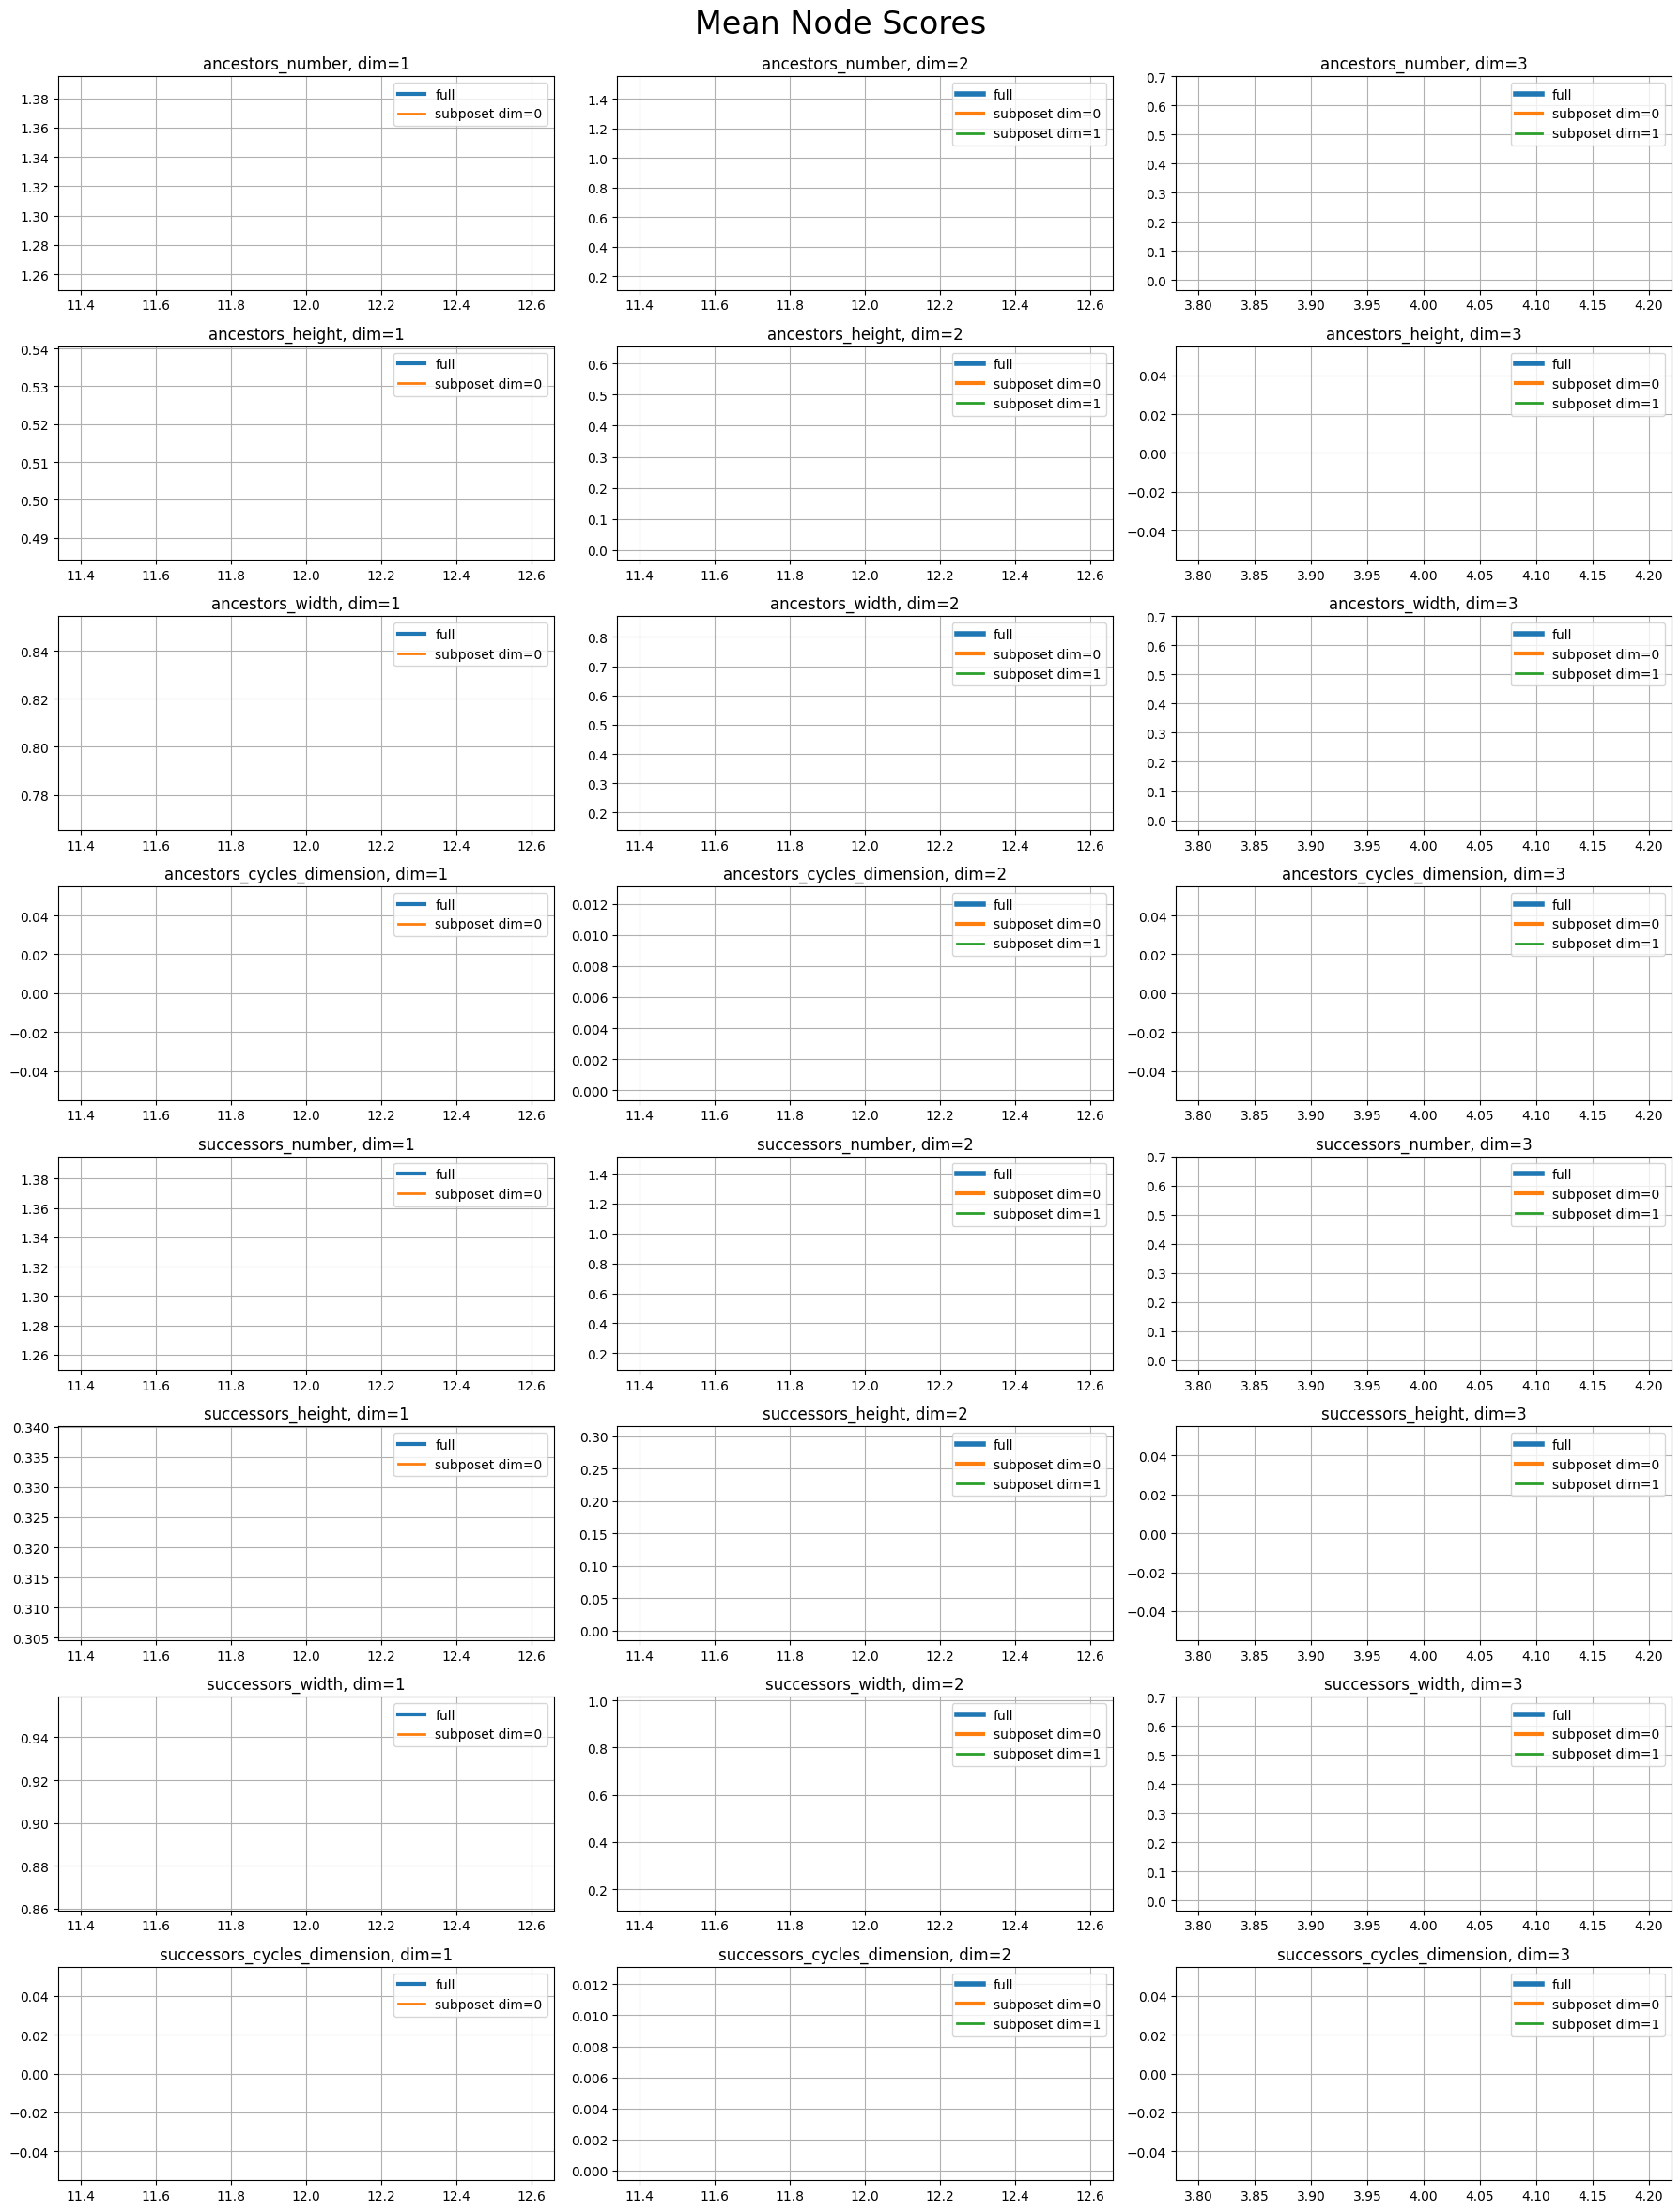

In [19]:
score_cols = interesting_node_scores_names

max_dim = df_node_scores['dim'].max()

fig, axs = plt.subplots(len(score_cols), max_dim)

fig.suptitle('Mean Node Scores', fontsize=24)
fig.set_figwidth(18)
fig.set_figheight(24)

for iscore, score in enumerate(score_cols):
    for dim in range(1, max_dim + 1):
        title = f'{score}, dim={dim}'
        axs[iscore, dim - 1].set_title(title)
        df_use = df_node_scores[df_node_scores['dim'] == dim][['n', 'object', score]].groupby(['n', 'object']).mean('score').reset_index().pivot(columns='object', index='n', values=score)
        for icol, col in enumerate(df_use.columns):
            axs[iscore, dim - 1].plot(df_use.index, df_use[col], label=col, linewidth=(len(df_use.columns) + 1 - icol))
        axs[iscore, dim - 1].legend()
        axs[iscore, dim - 1].grid(True)
        
plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig('raports/pics/scores - mean node scores.png')

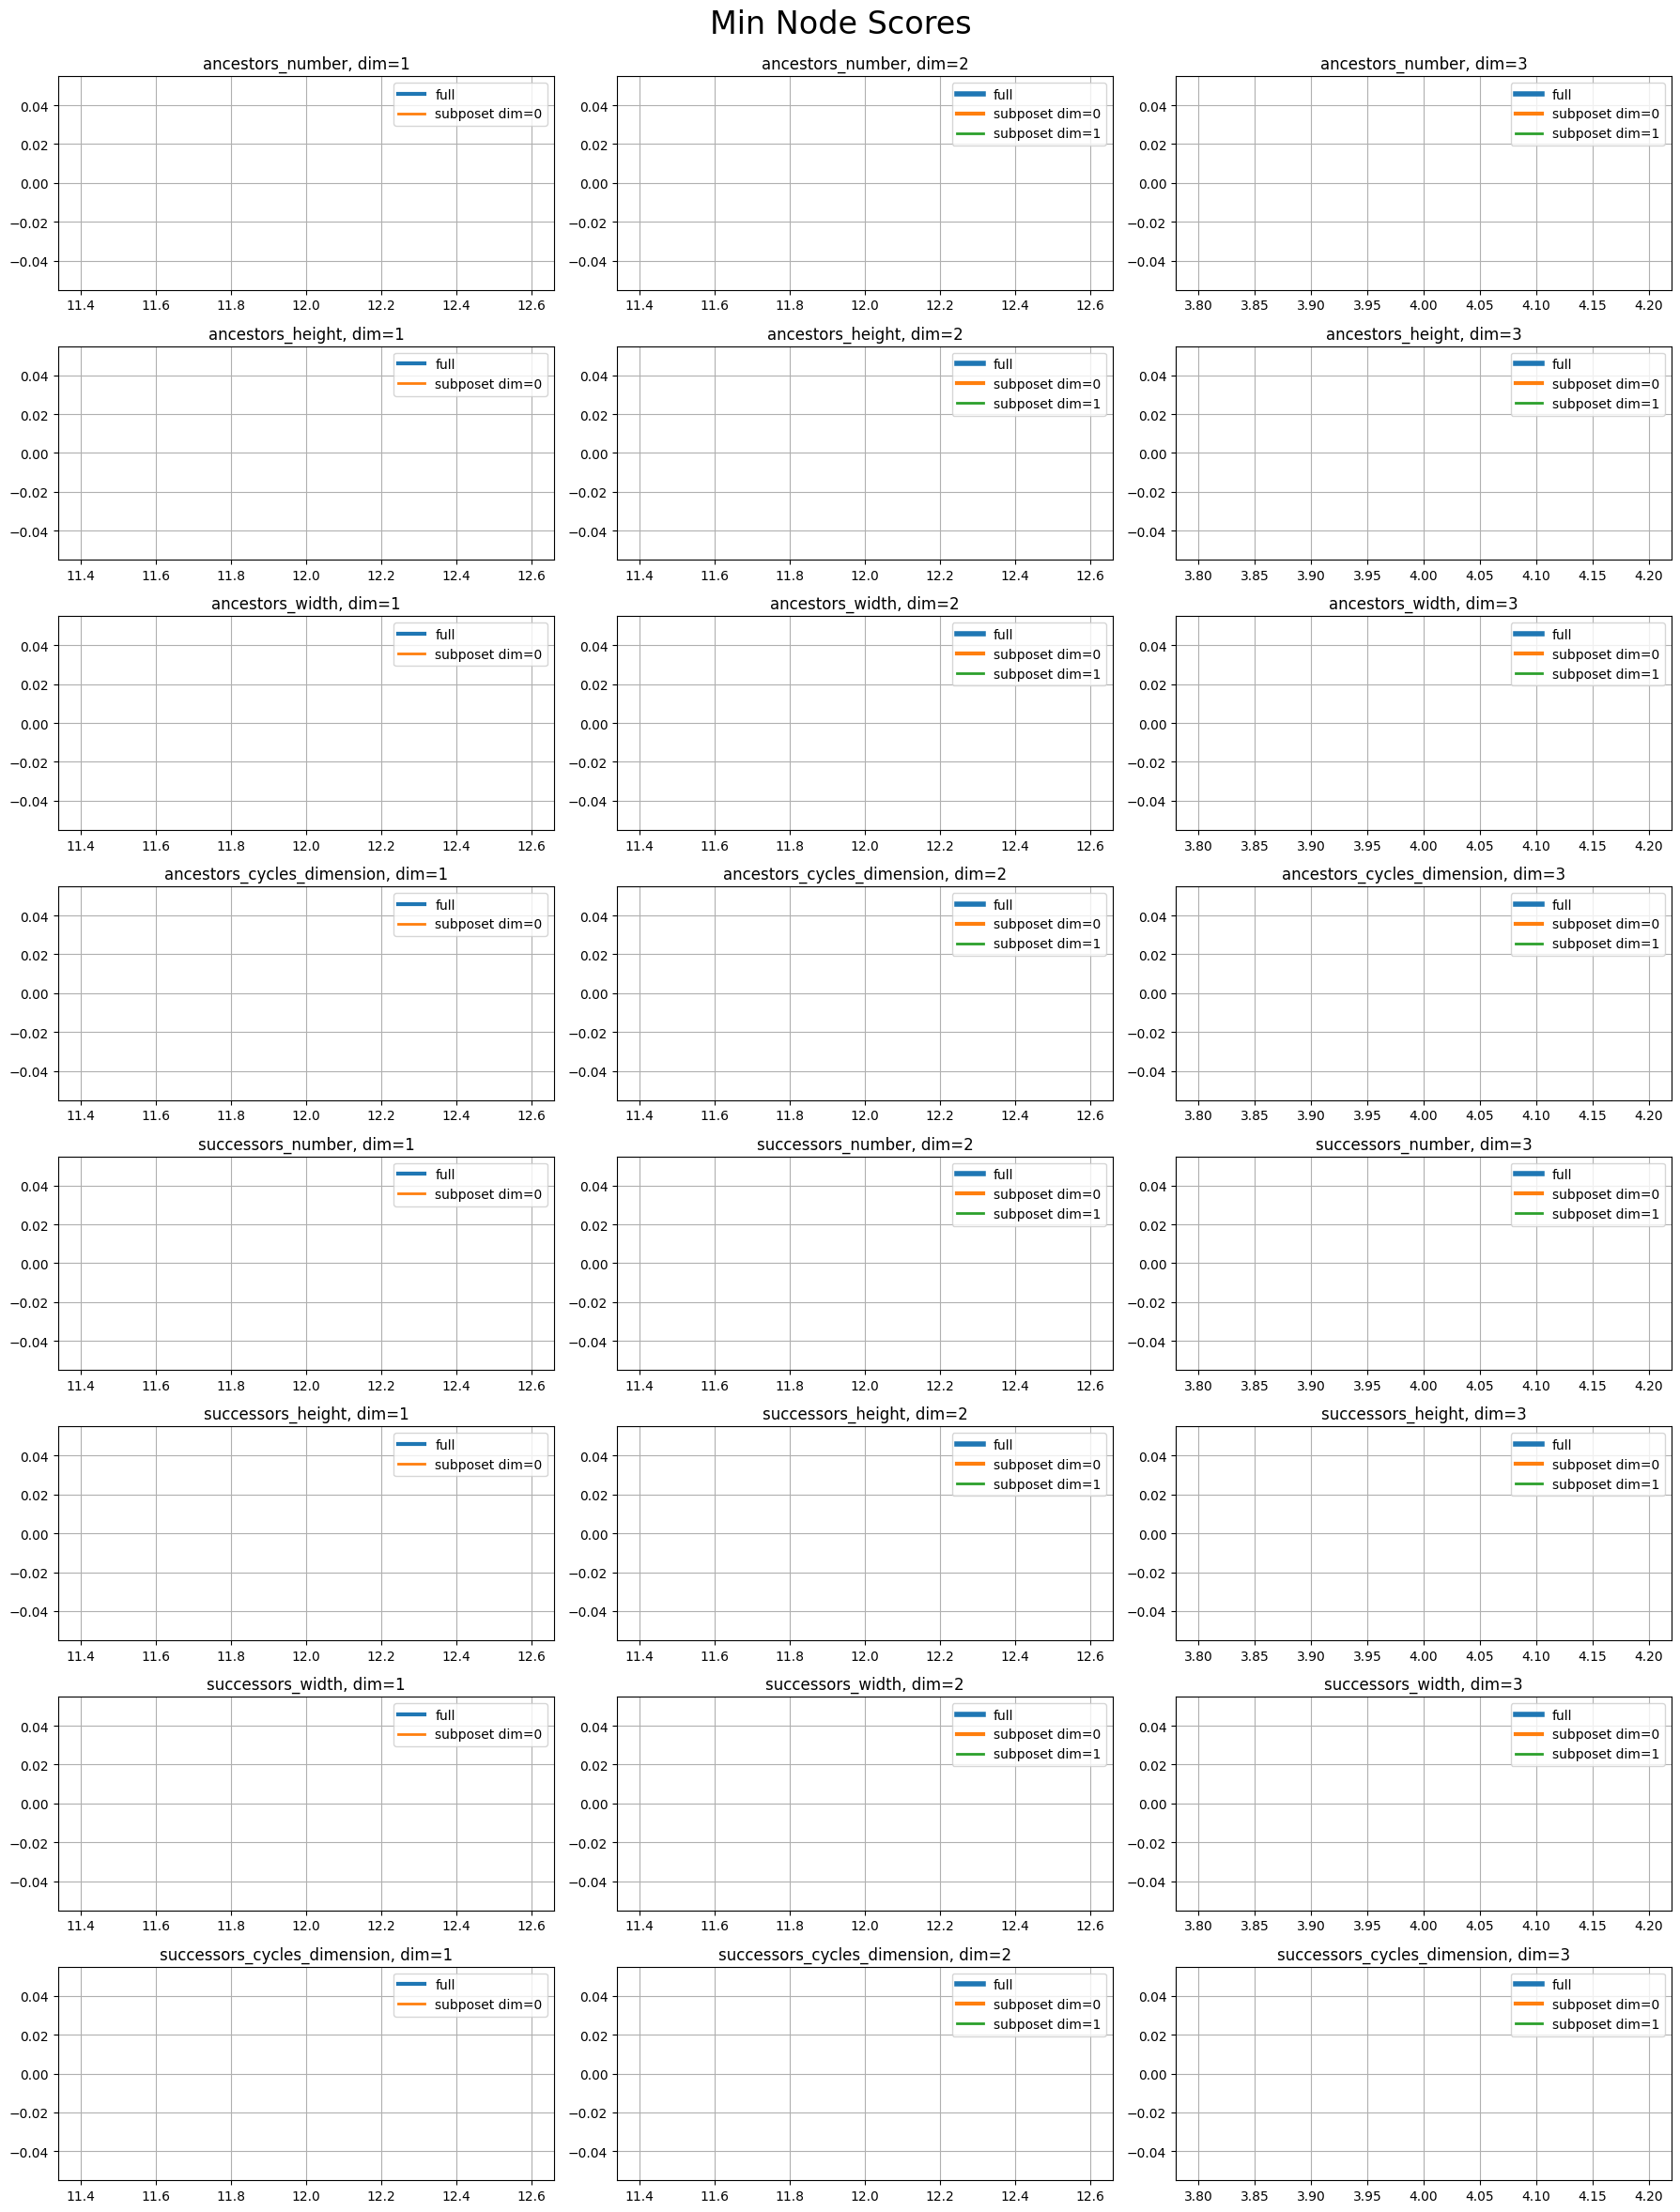

In [20]:
score_cols = interesting_node_scores_names
max_dim = df_node_scores['dim'].max()

fig, axs = plt.subplots(len(score_cols), max_dim)

fig.suptitle('Min Node Scores', fontsize=24)
fig.set_figwidth(18)
fig.set_figheight(24)

for iscore, score in enumerate(score_cols):
    for dim in range(1, max_dim + 1):
        title = f'{score}, dim={dim}'
        axs[iscore, dim - 1].set_title(title)
        df_use = df_node_scores[df_node_scores['dim'] == dim][['n', 'object', score]].groupby(['n', 'object']).min().reset_index().pivot(columns='object', index='n', values=score)
        for icol, col in enumerate(df_use.columns):
            axs[iscore, dim - 1].plot(df_use.index, df_use[col], label=col, linewidth=(len(df_use.columns) + 1 - icol))
        axs[iscore, dim - 1].legend()
        axs[iscore, dim - 1].grid(True)
        
plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig('raports/pics/scores - min node scores.png')

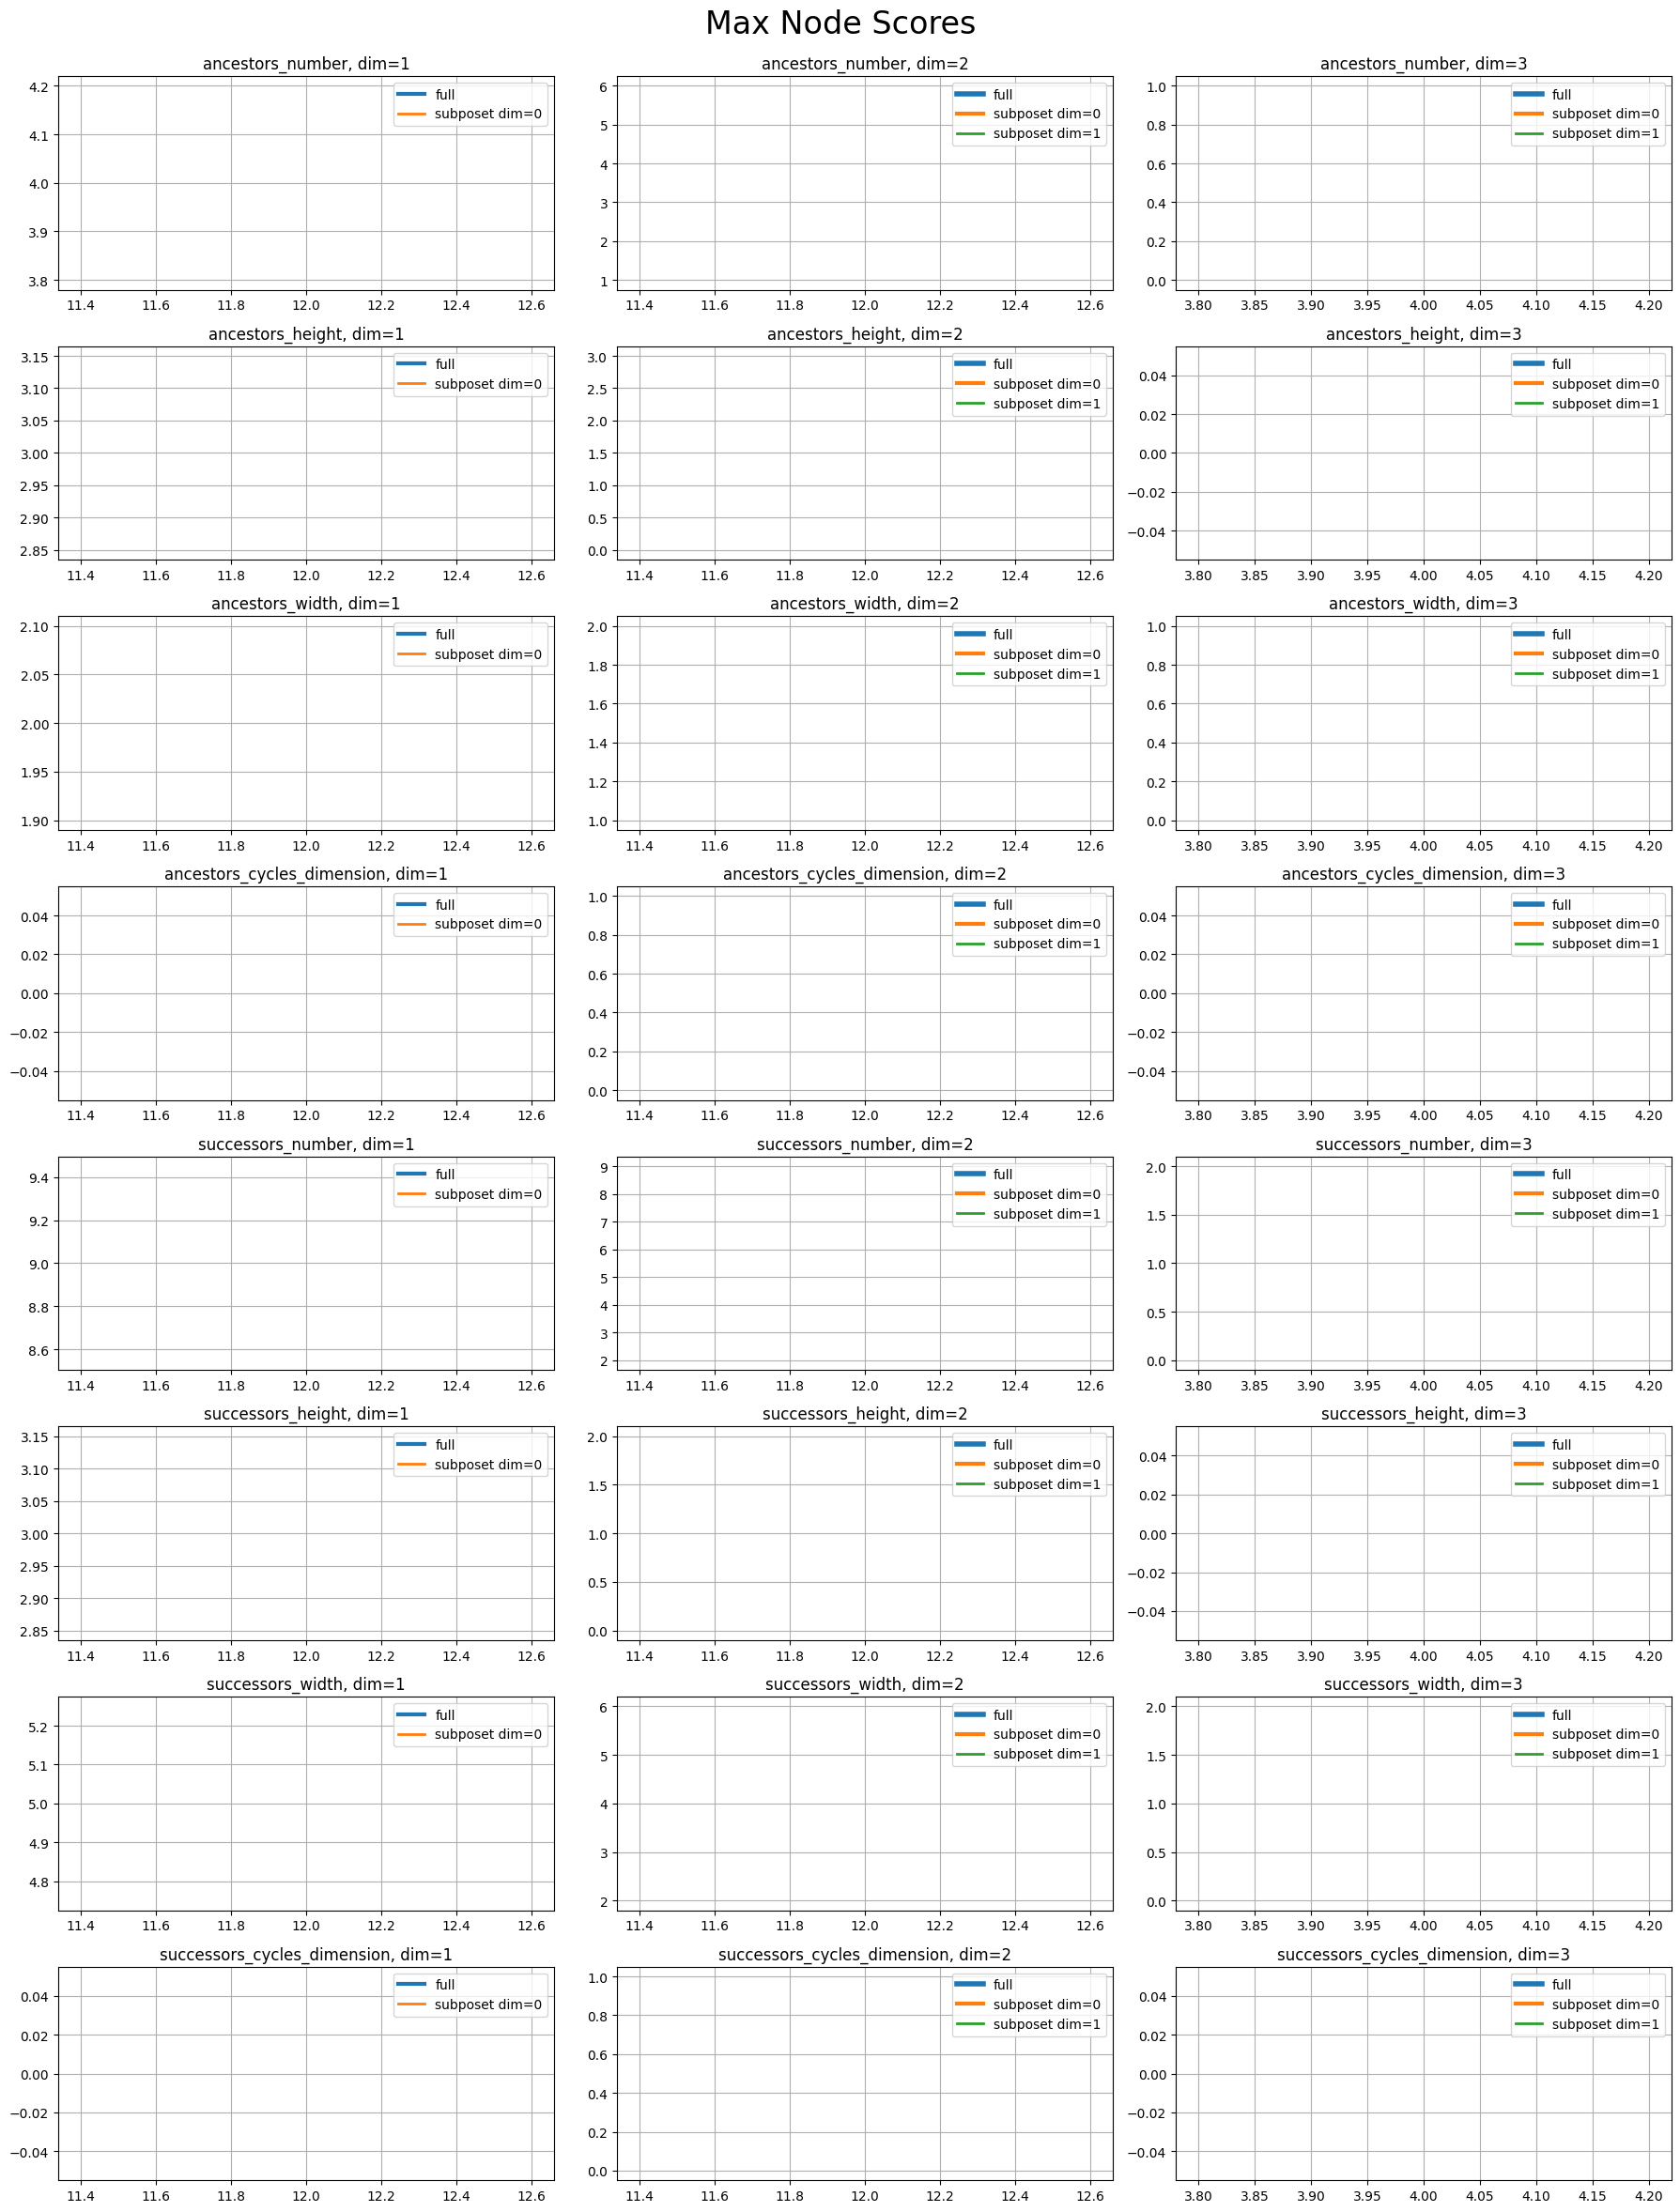

In [21]:
score_cols = interesting_node_scores_names
max_dim = df_node_scores['dim'].max()

fig, axs = plt.subplots(len(score_cols), max_dim)

fig.suptitle('Max Node Scores', fontsize=24)
fig.set_figwidth(18)
fig.set_figheight(24)

for iscore, score in enumerate(score_cols):
    for dim in range(1, max_dim + 1):
        title = f'{score}, dim={dim}'
        axs[iscore, dim - 1].set_title(title)
        df_use = df_node_scores[df_node_scores['dim'] == dim][['n', 'object', score]].groupby(['n', 'object']).max().reset_index().pivot(columns='object', index='n', values=score)
        for icol, col in enumerate(df_use.columns):
            axs[iscore, dim - 1].plot(df_use.index, df_use[col], label=col, linewidth=(len(df_use.columns) + 1 - icol))
        axs[iscore, dim - 1].legend()
        axs[iscore, dim - 1].grid(True)
        
plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig('raports/pics/scores - max node scores.png')

# Compile Raport Document

In [22]:
import src.poset_scores as poset_scores
import src.node_scores as node_scores
import inspect

In [23]:
def href_links(s: str, text='link') -> str:
    # replacing links in string with LaTeX format
    for w in s.split():
        if w[:6] == r'https:':
            if text is None:
                s = s.replace(w, f'\href{{{w}}}' + f'{{{w}}}'.replace('_', r'\_'))
            else:
                s = s.replace(w, f'\href{{{w}}}' + f'{{{text}}}')
    return s

In [24]:
# poset_scores description
s_poset_scores = r'\begin{itemize}' + '\n'

#for name, obj in inspect.getmembers(poset_scores, inspect.isfunction):
for obj, name in zip(interesting_poset_scores, interesting_poset_scores_names):
    if obj.__module__ == poset_scores.__name__:
        s_poset_scores += r"\item \textbf{" + name.replace('_', r'\_') + " }: " + href_links(obj.__doc__.strip()) + "\n"
s_poset_scores += r'\end{itemize}'

print(s_poset_scores)

\begin{itemize}
\item \textbf{number\_of\_nodes }: Returns the number of nodes in the poset.
\item \textbf{number\_of\_relations }: Returns the number of relations in the transitive reduction.
\item \textbf{number\_of\_components }: Returns the number of connetcted components in the poset
\item \textbf{cycles\_dimension }: Returns the dimension of space of cycles in reduction.
\item \textbf{number\_of\_minimal\_nodes }: Returns the number of minimal nodes.
\item \textbf{number\_of\_maximal\_nodes }: Returns the number of maximal nodes.
\item \textbf{height }: Returns the poset height - the length of the longest chain.
\item \textbf{width }: Returns the poset width - the length of the longest antichain (subset, s.t. all elements are pairwise incomparable).
    The algorithm is based on Dilworth's theorem and it's proof via Kőnig's theorem:
    \href{https://en.wikipedia.org/wiki/Dilworth%27s_theorem}{link}
\item \textbf{minimum\_maximal\_chain }: Returns the minimum size of maximal chai

In [25]:
# node_scores description
s_node_scores = r'\begin{itemize}' + '\n'

#for name, obj in inspect.getmembers(node_scores, inspect.isfunction):
for obj, name in zip(interesting_node_scores, interesting_node_scores_names):
    if obj.__module__ == node_scores.__name__:
        s_node_scores += r"\item \textbf{" + name.replace('_', r'\_') + "}: " + href_links(obj.__doc__.strip()) + "\n"
s_node_scores += r'\end{itemize}'

print(s_node_scores)

\begin{itemize}
\item \textbf{ancestors\_number}: Returns the number of nodes higher than given
\item \textbf{ancestors\_height}: Returns the size of maximum chain of subposet of nodes higher or equal than given
\item \textbf{ancestors\_width}: Returns the size of maximum chain of subposet of nodes higher or equal than given
\item \textbf{ancestors\_cycles\_dimension}: Returns the the dimension of space of cycles in reduction of subposet of nodes higher or equal than given
\item \textbf{successors\_number}: Returns the number of nodes higher than given
\item \textbf{successors\_height}: Returns the size of maximum chain of subposet of nodes lower or equal than given
\item \textbf{successors\_width}: Returns the size of maximum chain of subposet of nodes lower or equal than given
\item \textbf{successors\_cycles\_dimension}: Returns the the dimension of space of cycles in reduction of subposet of nodes lower or equal than given
\end{itemize}


In [26]:
# load texts, describing the process
with open('texts/scores - model.txt', 'r') as file:
    s_model = file.read()

with open('texts/scores - conclusion.txt', 'r') as file:
    s_coclusion = file.read()

# load LaTeX template
with open('texts/template.tex', 'r') as file:
    s_latex = file.read()

In [27]:
# parameters to include pictures containing scores
vspace_pt = -96
resize_width = 1.4
hspace_width = min(0, 0.5*(1 - resize_width))


body = f"""
\\section{{Model}}
{s_model}

\\section{{Scores}}
\\subsection{{Poset Scores}}
{s_poset_scores}

\\subsection{{Node Scores}}
{s_node_scores}

\\section{{Experiments and Results}}
\\par There are {len(df_cases)} experiments done. In the Figure \\ref{{fig:cases_distribution}} we can see how cases are distributed by size and dimension.
\\begin{{figure}}[ht]
  \\centering
  \\includegraphics[width=\\textwidth]{{pics/scores - cases.png}}
  \\caption{{Size/dimension distribution of experiments}}
  \\label{{fig:cases_distribution}}
\end{{figure}}

\\par In the Figure \\ref{{fig:scores_poset_mean}} we can see the avarage poset scores values for each number of points $n$.
\\begin{{figure}}[ht]
  \\vspace{{{vspace_pt}pt}}
  \\centering
  \\hspace*{{{hspace_width}\\textwidth}}
  \\resizebox{{{resize_width}\\textwidth}}{{!}}{{\\includegraphics[width=\\textwidth]{{pics/scores - mean poset scores.png}}}}
  \\caption{{Mean poset scores}}
  \\label{{fig:scores_poset_mean}}
\\end{{figure}}

\\par In the Figure \\ref{{fig:scores_node_mean}} we can see the avarage mean node scores values in poset for each number of points $n$.
\\begin{{figure}}[ht]
  \\vspace{{{vspace_pt}pt}}
  \\centering
  \\hspace*{{{hspace_width}\\textwidth}}
  \\resizebox{{{resize_width}\\textwidth}}{{!}}{{\\includegraphics[width=\\textwidth]{{pics/scores - mean node scores.png}}}}
  \\caption{{Mean node scores}}
  \\label{{fig:scores_node_mean}}
\\end{{figure}}

\\par In the Figure \\ref{{fig:scores_node_max}} we can see the avarage maximum node scores values in poset for each number of points $n$.
\\begin{{figure}}[ht]
  \\vspace{{{vspace_pt}pt}}
  \\centering
  \\hspace*{{{hspace_width}\\textwidth}}
  \\resizebox{{{resize_width}\\textwidth}}{{!}}{{\\includegraphics[width=\\textwidth]{{pics/scores - max node scores.png}}}}
  \\caption{{Max node scores}}
  \\label{{fig:scores_node_max}}
\\end{{figure}}

\\section{{Conclusion}}
{s_coclusion}

"""

if len(s_coclusion) == 0:
    body = body[:-24]

raport = s_latex.replace('BODY', body)
print(raport)

\documentclass{article}
\usepackage{amsfonts} 
\usepackage{hyperref}
\usepackage{graphicx}

\begin{document}


\section{Model}
\par The probabilistic model is simple. The first we just generate the cloud of $n$ points uniformly distributed in $[0, 1]^d$. After this we calculate the Alpha complex with these points, and then find its depth poset.

\section{Scores}
\subsection{Poset Scores}
\begin{itemize}
\item \textbf{number\_of\_nodes }: Returns the number of nodes in the poset.
\item \textbf{number\_of\_relations }: Returns the number of relations in the transitive reduction.
\item \textbf{number\_of\_components }: Returns the number of connetcted components in the poset
\item \textbf{cycles\_dimension }: Returns the dimension of space of cycles in reduction.
\item \textbf{number\_of\_minimal\_nodes }: Returns the number of minimal nodes.
\item \textbf{number\_of\_maximal\_nodes }: Returns the number of maximal nodes.
\item \textbf{height }: Returns the poset height - the length of th

In [28]:
with open('raports/scores.tex', 'w') as file:
    file.write(raport)

In [29]:
%cd raports
os.system('pdflatex scores.tex')
%cd ..

/nfs/scistore16/edelgrp/fzimin/depth-poset/raports
This is pdfTeX, Version 3.141592653-2.6-1.40.23 (TeX Live 2021) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./scores.tex
LaTeX2e <2021-06-01> patch level 1
L3 programming layer <2021-10-18>

/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]



(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/base/articl
e.cls
Document Class: article 2021/02/12 v1.4n Standard LaTeX document class

(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/base/size10
.clo))
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/amsfonts/am
sfonts.sty)
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/hyperref/hy
perref.sty
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/generic/ltxcmds/l
txcmds.sty)
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/generic/iftex/ift
ex.sty)
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/generic/pdftexcmd
s/pdftexcmds.sty
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/generic/infwarerr
/infwarerr.sty))
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/graphics/ke
yval.sty)
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/generic/kvsetkeys
/kvsetkeys.sty)
(/nfs/scist